## Library Imports

In [1]:
library(tidyverse)
library(kernlab)
library(glue)
library(kknn)
library(GGally)
library(outliers)

options(repr.plot.width=5, repr.plot.height=3)

set.seed(20)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘kernlab’

The following object is masked from ‘package:purrr’:

    cross

The following object is masked from ‘package:ggplot2’:

    alpha


Attaching package: ‘glue’

The following object is masked from ‘package:dplyr’:

    collapse


Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa



### Question 4.1

**Describe a situation or problem from your job, everyday life, current events, etc., for which a clustering
model would be appropriate. List some (up to 5) predictors that you might use.**

**ANSWER:**

I work for a financial technology start up focused on matching users with the best credit card or personal loan offer. Clustering users based on their credit report data is crucial in making the best recommendations. Below are 5 predictors that are commonly used:
1. Credit score
2. Length of credit history
3. Number of accounts
4. Debt amount
5. Late payments

### Question 4.2
**The iris data set iris.txt contains 150 data points, each with four predictor variables and one
categorical response. The predictors are the width and length of the sepal and petal of flowers and the
response is the type of flower. The data is available from the R library datasets and can be accessed with
iris once the library is loaded. It is also available at the UCI Machine Learning Repository
(https://archive.ics.uci.edu/ml/datasets/Iris ). The response values are only given to see how well a
specific method performed and should not be used to build the model.
Use the R function kmeans to cluster the points as well as possible. Report the best combination of
predictors, your suggested value of k, and how well your best clustering predicts flower type.**

In [2]:
iris_data <- read.table("../data/4.2irisSummer2018.txt", sep='', header=TRUE)

Check for null values just to make sure the data is clean.

In [3]:
for (col in colnames(iris_data)) {
    num_nulls  <- sum(is.na(iris_data$col))
    print(glue("{col} has {num_nulls} nulls"))
    }

Sepal.Length has 0 nulls
Sepal.Width has 0 nulls
Petal.Length has 0 nulls
Petal.Width has 0 nulls
Species has 0 nulls


Remove the Species column since that column should not be used in building the clustering model.

In [4]:
predictors <- iris_data[,c('Sepal.Length','Sepal.Width','Petal.Length','Petal.Width')]

#### Exploratory Data Analysis (EDA)

Explore the data! Create plots using different combinations of predictors to see if any two predictors can do a good job of clustering.

R has a great function called ggpairs that will show the correlation, distribution, and scatter plots between 2 of the predictors. There are a lot of plots so I will show just the few scatter plots that seemed to different flower species the best.

Plots are shown in the Appendix Section

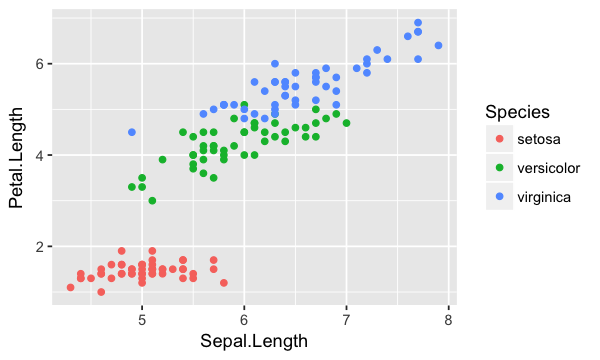

In [22]:
ggplot(data=iris_data) +   
    geom_point(mapping=aes(x=Sepal.Length, y=Petal.Length, color=Species))

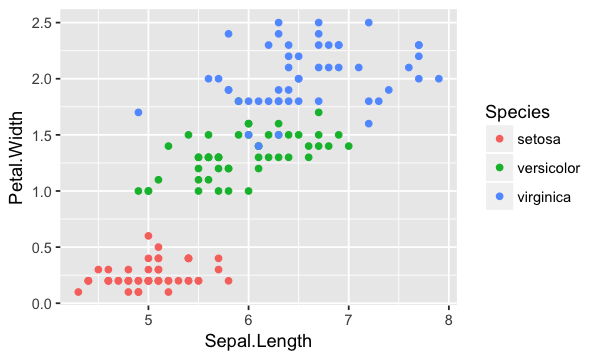

In [23]:
ggplot(data=iris_data) +   
    geom_point(mapping=aes(x=Sepal.Length, y=Petal.Width, color=Species))

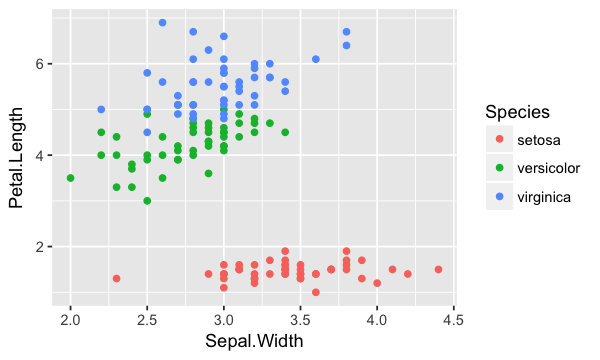

In [24]:
ggplot(data=iris_data) +   
    geom_point(mapping=aes(x=Sepal.Width, y=Petal.Length, color=Species))

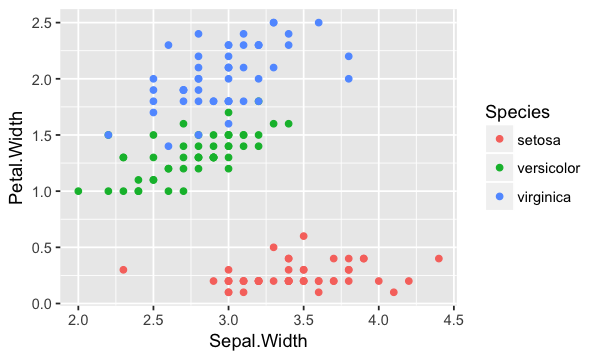

In [25]:
ggplot(data=iris_data) +   
    geom_point(mapping=aes(x=Sepal.Width, y=Petal.Width, color=Species))

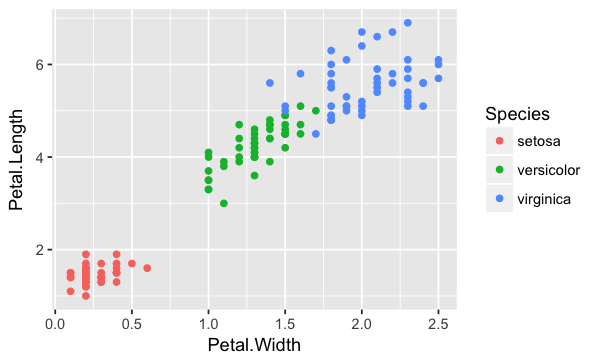

In [26]:
ggplot(data=iris_data) +   
    geom_point(mapping=aes(x=Petal.Width, y=Petal.Length, color=Species))

From these plots, the biggest takeaway I found was that even with just two predictors decent clusters can be formed.

In [5]:
cor(predictors)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
Sepal.Length,1.0000000,-0.1175698,0.8717538,0.8179411
Sepal.Width,-0.1175698,1.0000000,-0.4284401,-0.3661259
Petal.Length,0.8717538,-0.4284401,1.0000000,0.9628654
Petal.Width,0.8179411,-0.3661259,0.9628654,1.0000000


I also used the cor() function to get the correlation matrix to see which predictors are highly correlated.

It seems that sepal length is highly correlated with petal length and petal width. Using these three predictors in the clustering algorithm might prove to be effective.

#### Clustering

The first pass at creating clusters will use all 4 predictors to establish a baseline. A k-value of 3 is used since there are only three flower species: Setosa, Versicolor, and Virginica.

In [6]:
clusters <- kmeans(predictors, centers=3, nstart=20)

labels <- as.factor(clusters$cluster)

table(labels, iris_data$Species)

      
labels setosa versicolor virginica
     1      0          2        36
     2      0         48        14
     3     50          0         0

The table above compares the cluster labels vs the actual species. Setosa is easily separable since all 50 data points fall into one label. 48 of 50 (96%) of Versicolor data points are also pretty easily separable. 36 of 50 (72%) of Virginica data points are the least separable of the three species.

The next pass at clustering is using just two predictors: sepal length, petal width, and petal length. These three were chosen to due their high correlation with one another.

In [7]:
clusters_3pred <- kmeans(iris_data[, c('Sepal.Length',
                                       'Petal.Length',
                                       'Petal.Width')], centers=3, nstart=20)

labels_3pred <- as.factor(clusters_3pred$cluster)

table(labels_3pred, iris_data$Species)

            
labels_3pred setosa versicolor virginica
           1      0         48        14
           2     50          0         0
           3      0          2        36

The clustering performed similarly to the first pass. Setosa was still easily separated.

Since, the model built on three predictors performed just as well as the model built on all four, I decided to use those three predictors and vary the k-value instead.

In [8]:
for (i in 2:5) {
    print(glue("For {i} clusters, the confusion matrix is: "))
    temp_clusters <- kmeans(iris_data[, c('Sepal.Length',
                                          'Petal.Length',
                                          'Petal.Width')], centers=i, nstart=20)

    temp_labels <- as.factor(temp_clusters$cluster)

    print(table(temp_labels, iris_data$Species))
}


For 2 clusters, the confusion matrix is: 
           
temp_labels setosa versicolor virginica
          1      0         46        50
          2     50          4         0
For 3 clusters, the confusion matrix is: 
           
temp_labels setosa versicolor virginica
          1      0         48        14
          2     50          0         0
          3      0          2        36
For 4 clusters, the confusion matrix is: 
           
temp_labels setosa versicolor virginica
          1     50          0         0
          2      0         23        22
          3      0         27         1
          4      0          0        27
For 5 clusters, the confusion matrix is: 
           
temp_labels setosa versicolor virginica
          1      0          0        25
          2      0         27         1
          3     50          0         0
          4      0          0        12
          5      0         23        12


With a k-value of 2, the separation is very good. 50/50 setosa data points and 50/50 virginica data points were separated and 46/50 versicolor data points were separated. What this also says is that versicolor and virginica may be similar enough to be contained within the same cluster.

With a k-value of 4 and 5, the separation for setosa is still perfect (50/50), but the algorithm is now more confused about how to correctly cluster versicolor and virginica.

The best performing kmeans model was the one with a k-value = 3 and three predictors (sepal length, petal length, and petal width).

### Question 5.1
**Using crime data from the file uscrime.txt (http://www.statsci.org/data/general/uscrime.txt,
description at http://www.statsci.org/data/general/uscrime.html), test to see whether there are any
outliers in the last column (number of crimes per 100,000 people). Use the grubbs.test function in
the outliers package in R.**

In [9]:
crime_data <- read.table('../data/5.1uscrimeSummer2018.txt', sep='', header=TRUE)

The Grubbs test checks to see if the min or max value in a set of data is an outlier. 

In [10]:
grubbs.test(crime_data$Crime, type=10, opposite=FALSE)


	Grubbs test for one outlier

data:  crime_data$Crime
G = 2.81290, U = 0.82426, p-value = 0.07887
alternative hypothesis: highest value 1993 is an outlier


In [11]:
grubbs.test(crime_data$Crime, type=10, opposite=TRUE)


	Grubbs test for one outlier

data:  crime_data$Crime
G = 1.45590, U = 0.95292, p-value = 1
alternative hypothesis: lowest value 342 is an outlier


Given a 95% confidence level, a p-value of <= 0.05 was needed to consider a value to be an outlier. Since the p-values for the minimum and the maximum values are greater than 0.05, neither points can be considered outliers.

If we loosen the criteria to 90% confidence level, then a p-value of <= 0.10 is needed. In this case, then the maximum value (1993) is now considered an outlier.

I was interested to see if any other columns had outliers, so I decided to loop through the other columns. The loop below goes through each column and tests the min and max values found in each column using the Grubbs test. The p-value is found for both tests and if its <= 0.05, then the print statement is triggered.

In [12]:
for (col in colnames(crime_data)) {
    test_max <- grubbs.test(crime_data[, col], type=10, opposite=FALSE)
    test_min <- grubbs.test(crime_data[, col], type=10, opposite=TRUE)
    
    max_p <- test_max$p.value
    min_p <- test_max$p.value
    
    max_val <- max(crime_data[, col])
    min_val <- min(crime_data[, col])
    
    if (max_p <= 0.05) {
        print(glue("For {col}, the max value ({max_val}) is an outlier with a p-value of {max_p}"))
    }
    
    if (min_p <- 0.05) {
        print(glue("For {col}, the max value ({min_val}) is an outlier with a p-value of {min_p}"))
    }
}

For M, the max value (17.7) is an outlier with a p-value of 0.0302635052930932
For M, the max value (11.9) is an outlier with a p-value of 0.05
For So, the max value (0) is an outlier with a p-value of 0.05
For Ed, the max value (8.7) is an outlier with a p-value of 0.05
For Po1, the max value (4.5) is an outlier with a p-value of 0.05
For Po2, the max value (4.1) is an outlier with a p-value of 0.05
For LF, the max value (0.48) is an outlier with a p-value of 0.05
For M.F, the max value (107.1) is an outlier with a p-value of 0.0405410887662231
For M.F, the max value (93.4) is an outlier with a p-value of 0.05
For Pop, the max value (168) is an outlier with a p-value of 0.00510193481485421
For Pop, the max value (3) is an outlier with a p-value of 0.05
For NW, the max value (42.3) is an outlier with a p-value of 0.0222986767277551
For NW, the max value (0.2) is an outlier with a p-value of 0.05
For U1, the max value (0.07) is an outlier with a p-value of 0.05
For U2, the max value (2)

It seems that there are outliers within this data set according to the Grubbs test. What's interesting is that most of these p-values are at 0.05 so if I had set the confidence level higher to 99%, then most of these outliers would no longer be outliers.

### Question 6.1
**Describe a situation or problem from your job, everyday life, current events, etc., for which a Change
Detection model would be appropriate. Applying the CUSUM technique, how would you choose the
critical value and the threshold?**

**ANSWER:**

At my previous job, I worked as a packaging engineer at a winery. One of my responsibilities was to monitor our bottling lines to make sure that the # of broken bottles were below a certain threshold. The Change Detection model would be appropriate in this case because we would track the # of broken bottles as a function of time and once that # got above a certain threshold, then adjustments on the bottling line would be made to bring back the # to below the threshold.

In this scenario, the bottling speed was generally around 200 bottles per minute or 12,000 bottles per hour. We wanted a less than 1% broken bottle rate so the threshold was set to be 120 (1% of 12,000). The C-value was kept at 0 for most bottling lines since we would rather detect a false change and adjust the line than fail to detect a change and have broken bottles jam the line. Adjusting the line was a simple fix that would only take 3-5 minutes max, but clearing a jam on the line could take upwards of an hour.

### Question 6.2
**1) Using July through October daily-high-temperature data for Atlanta for 1996 through 2015, use
a CUSUM approach to identify when unofficial summer ends (i.e., when the weather starts
cooling off) each year. You can get the data that you need from the file temps.txt or online,
for example at http://www.iweathernet.com/atlanta-weather-records or
https://www.wunderground.com/history/airport/KFTY/2015/7/1/CustomHistory.html . You can
use R if you’d like, but it’s straightforward enough that an Excel spreadsheet can easily do the
job too.**

In [13]:
temp_data <- read.table('../data/6.2tempsSummer2018.txt', sep='', header=TRUE)

I wrote a function that uses the CUSUM approach to find the index at which the threshold value is passed.

In [14]:
# cusum_approach takes in the data of interest, threshold (T), critical value (C), mean (mu), 
# and a boolean value for is_inc.
# The is_inc determines whether the change that is being detected is an increase or decrease.
cusum_approach <- function(data, T, C, mu, is_inc) {
    S_t <- 0
    
    if (isTRUE(is_inc)) {
        for (i in 1:length(data)) {
            S_t <- S_t - mu + data[i] - C
            # Check if the S_t is less than 0, if it is then it should be 
            # reset to 0
            if (S_t <= 0) {
                S_t <- 0
                }
            # Check if S_t is greater than the threshold, if it is then 
            # the loop ends
            if (S_t > T) {
                end_index <- i
                break
            }
        }
    }

    else {
        for (i in 1:length(data)) {
            S_t <- S_t + mu - data[i] - C
            # Check if the S_t is less than 0, if it is then it should be 
            # reset to 0
            if (S_t <= 0) {
                S_t <- 0
                }
            # Check if S_t is greater than the threshold, if it is then 
            # the loop ends
            if (S_t > T) {
                end_index <- i
                break
            }
        }
    }
    return(end_index)
}

Using the function above, the approximate last day of summer is calculated for a threshold = 20 and C = 5. A threshold of 20 was chosen since a change in 20 degrees from summer to fall seems like a reasonable indication that summer has ended. 

The C value is a bit trickier to initialize since I don't know what a reasonable value would be.

In [15]:
# Set threshold (T) and critical value (C)
T <- 20
C <- 5

In [16]:
for (i in 2:ncol(temp_data)) {
    # Initialize the mean (mu) and the cumulative sum (S_t)
    mu <- mean(temp_data[,i])
    S_t <- 0

    # Get the index at which the threshold is passed.
    end_index <- cusum_approach(temp_data[,i], T, C, mu, is_inc=FALSE)

    summer_end_date <- temp_data[end_index,1]
    year <- substr(colnames(temp_data)[i], 2, 5)
    print(glue("Summer ends on {summer_end_date} in the year {year}"))
    
    }

Summer ends on 30-Sep in the year 1996
Summer ends on 27-Sep in the year 1997
Summer ends on 9-Oct in the year 1998
Summer ends on 30-Sep in the year 1999
Summer ends on 7-Sep in the year 2000
Summer ends on 26-Sep in the year 2001
Summer ends on 27-Sep in the year 2002
Summer ends on 1-Oct in the year 2003
Summer ends on 12-Oct in the year 2004
Summer ends on 9-Oct in the year 2005
Summer ends on 13-Oct in the year 2006
Summer ends on 12-Oct in the year 2007
Summer ends on 19-Oct in the year 2008
Summer ends on 5-Oct in the year 2009
Summer ends on 30-Sep in the year 2010
Summer ends on 8-Sep in the year 2011
Summer ends on 3-Oct in the year 2012
Summer ends on 17-Aug in the year 2013
Summer ends on 29-Sep in the year 2014
Summer ends on 26-Sep in the year 2015


With a C value of 5, summer tends to end near the end of September. This might be reasonable, but I'll try a lower C value and see if the summers tend to end earlier.

In [17]:
# Set threshold (T) and critical value (C)
T <- 20
C <- 1

In [18]:
for (i in 2:ncol(temp_data)) {
    # Initialize the mean (mu) and the cumulative sum (S_t)
    mu <- mean(temp_data[,i])
    S_t <- 0

    # Get the index at which the threshold is passed.
    end_index <- cusum_approach(temp_data[,i], T, C, mu, is_inc=FALSE)

    summer_end_date <- temp_data[end_index,1]
    year <- substr(colnames(temp_data)[i], 2, 5)
    print(glue("Summer ends on {summer_end_date} in the year {year}"))
    
    }

Summer ends on 21-Sep in the year 1996
Summer ends on 25-Sep in the year 1997
Summer ends on 30-Sep in the year 1998
Summer ends on 20-Sep in the year 1999
Summer ends on 6-Sep in the year 2000
Summer ends on 25-Sep in the year 2001
Summer ends on 25-Sep in the year 2002
Summer ends on 29-Sep in the year 2003
Summer ends on 19-Sep in the year 2004
Summer ends on 7-Oct in the year 2005
Summer ends on 21-Sep in the year 2006
Summer ends on 17-Sep in the year 2007
Summer ends on 21-Sep in the year 2008
Summer ends on 2-Oct in the year 2009
Summer ends on 28-Sep in the year 2010
Summer ends on 7-Sep in the year 2011
Summer ends on 30-Sep in the year 2012
Summer ends on 16-Aug in the year 2013
Summer ends on 26-Sep in the year 2014
Summer ends on 16-Sep in the year 2015


This seems more reasonable since the summer seems to end more towards mid-early September.

**2) Use a CUSUM approach to make a judgment of whether Atlanta’s summer climate has gotten
warmer in that time (and if so, when).**

I interpreted this question to mean that I should look at reach row and determine, as the years went by, if the temperature was rising. Setting the T and C values was a bit tricky. Since there aren't many years worth of data (~20 years) and for each day, the temperature can fluctuate a lot. To account for the high variance I set the C value relatively high at 5 and the T value relatively high as well at 10. This meant that the algorithm would hopefully not be tricked by false positives (or high variance in the data).

In [19]:
# Set threshold (T) and critical value (C)
T <- 10
C <- 5

For each day (July 1 - Oct 31), I found the starting temperature and the year at which the threshold value was surpassed. 2011 seems to be most common year at which the threshold was surpassed followed by 2009.

In [21]:
for (i in 1:nrow(temp_data)) {
    # Initialize the mean (mu) and the cumulative sum (S_t)
    mu <- rowMeans(temp_data[i,c(2:ncol(temp_data))])
    S_t <- 0

    # Get the index at which the threshold is passed.
    end_index <- cusum_approach(temp_data[i,2:21], T, C, mu, is_inc=TRUE)
    
    start_temp <- temp_data[i,2]
    start_date <- temp_data[i,1] 
    print(glue("For start date, {start_date}:"))
    print(glue("The starting temperature was {start_temp}F."))
    
    end_year <- substr(colnames(temp_data)[end_index], 2, 5)
    if (all.equal(end_index, as.integer(end_index)) == TRUE) {
        print(glue("The year when the threshold was surpassed was {end_year}"))
    }
    else {
        print("The threshold was never surpassed.")
    }
    }

For start date, 1-Jul:
The starting temperature was 98F.
The year when the threshold was surpassed was 2011
For start date, 2-Jul:
The starting temperature was 97F.
The year when the threshold was surpassed was 2011
For start date, 3-Jul:
The starting temperature was 97F.
The year when the threshold was surpassed was 2011
For start date, 4-Jul:
The starting temperature was 90F.
The year when the threshold was surpassed was 2011
For start date, 5-Jul:
The starting temperature was 89F.
The year when the threshold was surpassed was 2011
For start date, 6-Jul:
The starting temperature was 93F.
The year when the threshold was surpassed was 2011
For start date, 7-Jul:
The starting temperature was 93F.
The year when the threshold was surpassed was 2011
For start date, 8-Jul:
The starting temperature was 91F.
The year when the threshold was surpassed was 2011
For start date, 9-Jul:
The starting temperature was 93F.
The year when the threshold was surpassed was 2011
For start date, 10-Jul:
The 